In [1]:
from task2_utils import *
warnings.filterwarnings('ignore')
# interactive plot
%matplotlib widget

In [2]:
fd_collection = getCollection("team_5_mwdb_phase_2", "fd_collection")

In [3]:
def calculate_image_similarity(data, distance_measure):
    """Object-object similarity with given distance measure"""
    n = data.shape[0]
    image_sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            image_sim_matrix[i][j] = image_sim_matrix[j][i] = distance_measure(
                np.array(data[i]), np.array(data[j])
            )
    return image_sim_matrix

In [4]:
def mds_projection(data_sim_matrix, n_components=2):
    """MDS projection to n-D space"""
    n = data_sim_matrix.shape[0]
    # Centering matrix
    C = np.eye(n) - np.ones((n, n)) / n
    # B = -1/2 * C * D^2 * C
    B = -0.5 * C @ (data_sim_matrix**2) @ C
    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(B)

    # Sort eigenvalues and corresponding eigenvectors
    indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[indices]
    eigvecs = eigvecs[:, indices]

    # Take the first n_components eigenvectors
    components = eigvecs[:, :n_components]

    return components

In [5]:
def avgandmin_knn_distance(data_sim_matrix, k):
    """Get avg. and minimum k-th nearest neighbor distance"""
	# Sort each row of the distance matrix and extract the kth-nearest neighbor distance
    kth_neighbor_distances = np.sort(data_sim_matrix, axis=1)[:, k-1]

    # Understanding KNN distribution to figure out strategy to find epsilon range
    # plt.plot(np.sort(kth_neighbor_distances))
    # plt.show()
    
    # Calculate the average and minimum distance of the kth-nearest neighbor
    average_distance = np.mean(kth_neighbor_distances)
    minimum_distance = np.min(kth_neighbor_distances)

    return average_distance, minimum_distance


In [6]:
def display_cluster_stats(clusters):
    """Display cluster counts and noise point count"""
    cluster_counts = np.unique(clusters, return_counts=True)
    cluster_counts_dict = dict(
        (unique_label, unique_count)
        for unique_label, unique_count in zip(cluster_counts[0], cluster_counts[1])
    )
    print("Clusters:", cluster_counts_dict)
    print("No. of clusters:", len(cluster_counts_dict.keys() - {-1}))
    if -1 in cluster_counts_dict:
        print("Noise points:", cluster_counts_dict[-1])
    else:
        print("No noise points")

In [10]:
class DBSCAN:
    def __init__(self, data, distance_measure, eps, min_samples, data_sim_matrix=None):
        self.eps = eps
        self.min_samples = min_samples

        self.data = data
        self.distance_measure = distance_measure
        self.num_images = data.shape[0]

        self.image_sim_matrix = np.zeros((self.num_images, self.num_images))
        if data_sim_matrix is not None:
            self.image_sim_matrix = data_sim_matrix
        self.clusters = np.zeros(self.num_images)  # 0 represents unclassified points

    def dbscan(self):
        """DBSCAN algorithm"""
        # if similarities not provided/calculated already
        if np.array_equal(
            self.image_sim_matrix, np.zeros((self.num_images, self.num_images))
        ):
            calculate_image_similarity(self.data, self.distance_measure)

        cluster_id = 0
        for i in range(self.num_images):
            if self.clusters[i] != 0:
                continue  # Skip already classified points

            neighbors = self.region_query(i)
            if len(neighbors) < self.min_samples:
                self.clusters[i] = -1  # Mark point as noise
            else:
                cluster_id += 1  # New cluster identified
                self.clusters[i] = cluster_id
                self.grow_cluster(neighbors, cluster_id)

        return self.clusters

    def region_query(self, center):
        distances = self.image_sim_matrix[center]
        return [i for i, dist in enumerate(distances) if dist < self.eps]

    def grow_cluster(self, neighbors, cluster_id):
        i = 0
        # check neighbors for connected components
        while i < len(neighbors):
            neighbor = neighbors[i]

            if self.clusters[neighbor] == -1:
                self.clusters[neighbor] = cluster_id  # Change noise to border point
            elif self.clusters[neighbor] == 0:
                self.clusters[neighbor] = cluster_id
                new_neighbors = self.region_query(neighbor)
                # If new point could be a core point
                if len(new_neighbors) >= self.min_samples:
                    neighbors += new_neighbors  # add its neighbors to list of neighbors to consider
            i += 1

    def mds_scatter_clusters(self):
        """Visualize clusters as point clouds in 2-D space"""
        # Perform MDS projection
        mds_components = mds_projection(self.image_sim_matrix)

        # Plot clusters
        plt.figure(figsize=(8, 6))
        for label in set(self.clusters):
            # to hide noise
            # if label == -1:
            #     continue
            cluster_points = mds_components[self.clusters == label]
            plt.scatter(
                cluster_points[:, 0],
                cluster_points[:, 1],
                label=f"{(f'Cluster {int(label)}') if label != -1 else 'Noise points'}",
            )

        plt.title("DBSCAN clusters projected onto 2-D MDS space")
        plt.xlabel("MDS component 1")
        plt.ylabel("MDS component 2")
        plt.legend()
        plt.show()

    def group_image_clusters(self, image_data):
        # Perform MDS projection
        mds_components = mds_projection(self.image_sim_matrix)
        # Scaling up to fit images inside
        mds_components = mds_components * 10000

        min_x_mds = np.min(mds_components[:, 0])
        min_y_mds = np.min(mds_components[:, 1])
        max_x_mds = np.max(mds_components[:, 0])
        max_y_mds = np.max(mds_components[:, 1])

        img_width = (max_x_mds - min_x_mds) / 10
        img_height = (max_y_mds - min_y_mds) / 10

        # Plot clusters
        plt.figure(figsize=(8, 8))
        for label in set(self.clusters):
            cluster_points = mds_components[self.clusters == label]
            plt.scatter(
                cluster_points[:, 0],
                cluster_points[:, 1],
                label=f"{(f'Cluster {int(label)}') if label != -1 else 'Noise points'}",
                zorder=1,
            )

            # Display image thumbnails at cluster centroids
            cluster_indices = np.where(self.clusters == label)[0]
            cluster_center = np.mean(mds_components[cluster_indices], axis=0)
            thumbnail_data = image_data[cluster_indices[0]].resize(
                (int(np.ceil(img_width)), int(np.ceil(img_height)))
            )
            im = plt.imshow(
                thumbnail_data,
                extent=(
                    cluster_center[0] - 0.5 * img_width,
                    cluster_center[0] + 0.5 * img_width,
                    cluster_center[1] - 0.5 * img_height,
                    cluster_center[1] + 0.5 * img_height,
                ),
                interpolation="nearest",
                cmap=plt.cm.gray_r,
                zorder=0,
            )

            # Image border
            x1, x2, y1, y2 = im.get_extent()
            (im_border,) = plt.plot(
                [x1, x2, x2, x1, x1],
                [y1, y1, y2, y2, y1],
                "-",
                linewidth=2,
                solid_capstyle="butt",
                zorder=0,
            )

            # Click to bring to front
            def region_click(event, region_area=im, region_border=im_border):
                if region_area.contains(event)[0]:
                    region_border.set_zorder(2)
                    region_area.set_zorder(2)
                else:
                    region_border.set_zorder(0)
                    region_area.set_zorder(0)

            im.figure.canvas.mpl_connect("button_press_event", region_click)

        plt.title("DBSCAN clusters projected onto 2-D MDS space")
        plt.xlabel("MDS component 1")
        plt.ylabel("MDS component 2")
        plt.xlim(min_x_mds, max_x_mds)
        plt.ylim(min_y_mds, max_y_mds)
        plt.legend()
        plt.show()

In [11]:
# selected_feature_model = valid_feature_models[
#     str(input("Enter feature model - one of " + str(list(valid_feature_models.keys()))))
# ]
selected_feature_model = valid_feature_models["avgpool"]
selected_distance_measure = feature_distance_matches[selected_feature_model]
# selected_distance_measure = euclidean_distance_measure
selected_c = 5

Label: 0
Epsilon: 0.10715872252338608 	MinPts: 3
Clusters: {-1.0: 94, 1.0: 15, 2.0: 94, 3.0: 3, 4.0: 4, 5.0: 8}
No. of clusters: 5
Noise points: 94


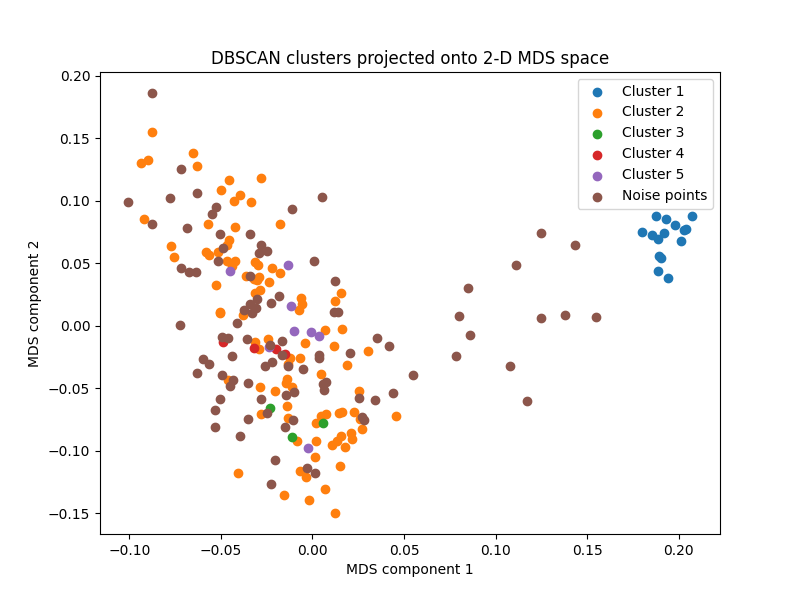

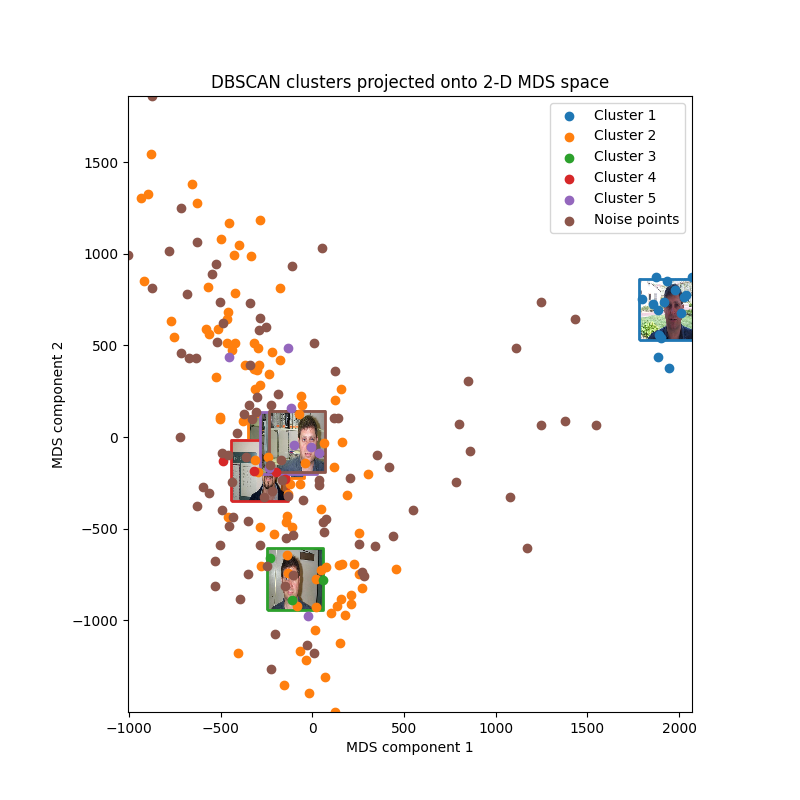

Label: 1
Epsilon: 0.11154326813785193 	MinPts: 7
Clusters: {-1.0: 32, 1.0: 154, 2.0: 11, 3.0: 4, 4.0: 8, 5.0: 8}
No. of clusters: 5
Noise points: 32


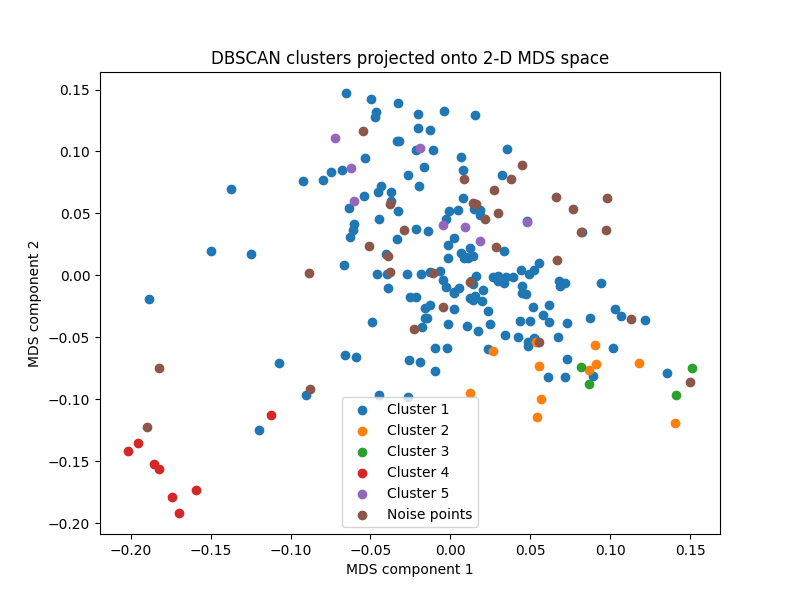

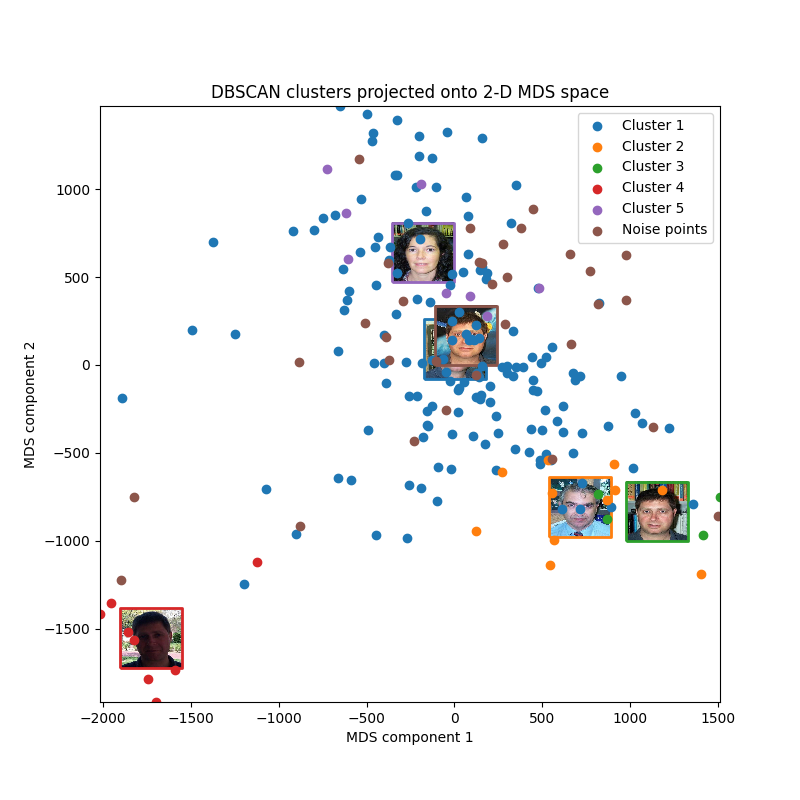

Label: 2
Epsilon: 0.041233333476868195 	MinPts: 3
Clusters: {-1.0: 60, 1.0: 4, 2.0: 4, 3.0: 8, 4.0: 4, 5.0: 20}
No. of clusters: 5
Noise points: 60


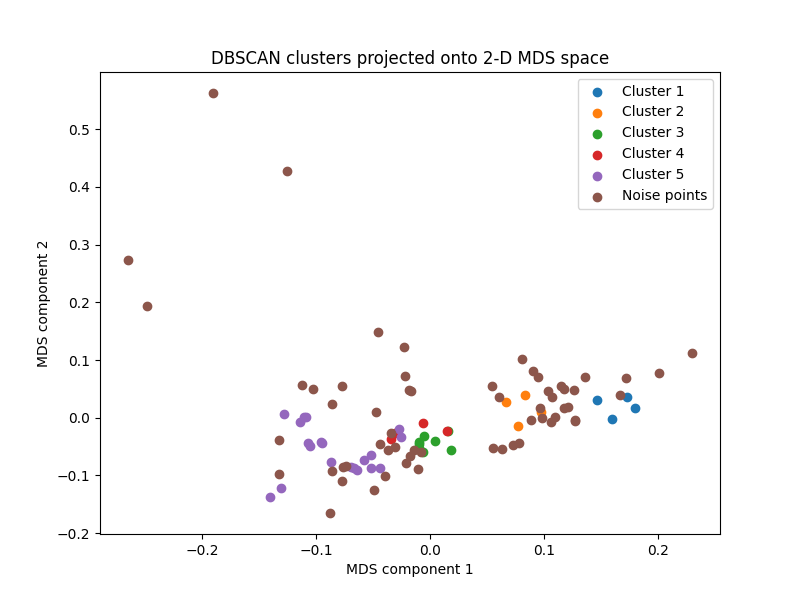

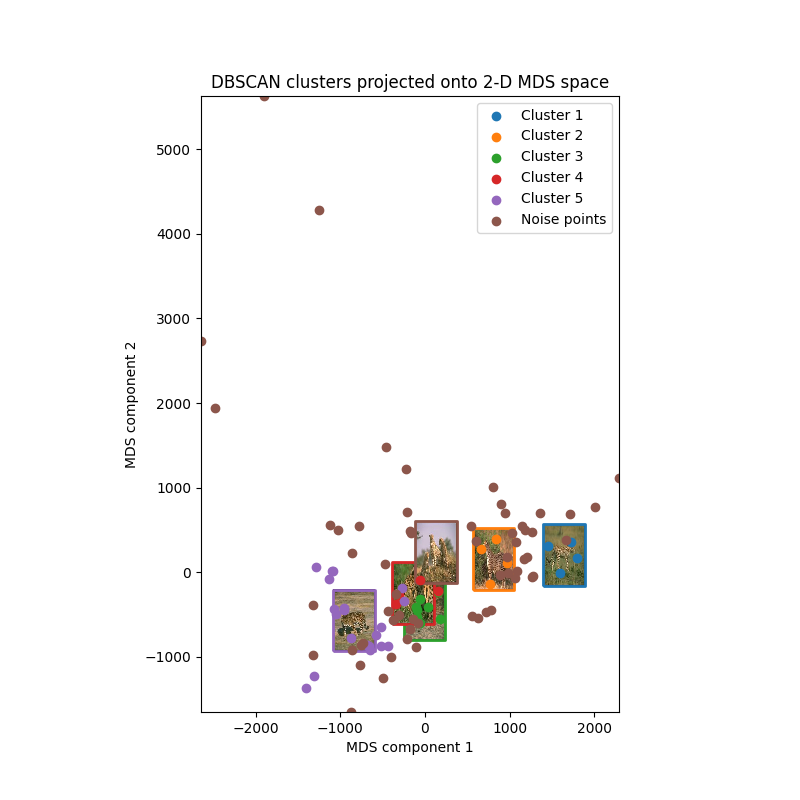

KeyboardInterrupt: 

In [12]:
all_label_clusterings = []
for label in range(NUM_LABELS):
    # get label's images in PIL format
    label_imgs = []
    label_img_ids = [
        label_img["image_id"] for label_img in fd_collection.find({"true_label": label})
    ]
    for img_id in label_img_ids:
        img, true_label = dataset[img_id]
        label_imgs.append(transforms.ToPILImage()(img))

    # get image features
    label_fds = np.array(
        [
            np.array(img_fds[selected_feature_model]).flatten()
            for img_fds in fd_collection.find({"true_label": label})
        ]
    )


    label_dbscan_results = (np.empty(label_fds.shape[0]), 0, 0)
    label_min_noise = label_fds.shape[0]

    label_img_sim_matrix = calculate_image_similarity(
        label_fds, selected_distance_measure
    )

    # decrementally try min_samples, starting from twice the desired no. of clusters
    for cur_min_samples in range(2 * selected_c, 1, -1):
        # find range of epsilon to try, by checking all from mean to min knn distance
        # k is current min_samples
        max_eps, min_eps = avgandmin_knn_distance(label_img_sim_matrix, cur_min_samples)

        # try epsilon values
        for cur_eps in np.linspace(min_eps, max_eps, num=100):
            label_dbscan = DBSCAN(
                label_fds,
                selected_distance_measure,
                cur_eps,
                cur_min_samples,
                label_img_sim_matrix,
            )

            clusters = label_dbscan.dbscan()

            # store only most desirable clustering: c clusters, minimum noise
            cluster_counts = np.unique(clusters, return_counts=True)
            cluster_counts_dict = dict(
                (unique_label, unique_count)
                for unique_label, unique_count in zip(
                    cluster_counts[0], cluster_counts[1]
                )
            )
            if (len(cluster_counts_dict.keys() - {-1}) == selected_c) and (
                cluster_counts_dict[-1] < label_min_noise
            ):
                label_dbscan_results = (clusters, cur_eps, cur_min_samples)
                label_min_noise = cluster_counts_dict[-1]

    # store best clustering
    all_label_clusterings.append(label_dbscan_results)
    print("Label:", label)
    print("Epsilon:", label_dbscan_results[1], "\tMinPts:", label_dbscan_results[2])
    display_cluster_stats(label_dbscan_results[0])

    best_label_dbscan = DBSCAN(
        label_fds,
        selected_distance_measure,
        label_dbscan_results[1],
        label_dbscan_results[2],
        label_img_sim_matrix,
    )
    best_label_dbscan.clusters = label_dbscan_results[0]
    # MDS point cloud
    best_label_dbscan.mds_scatter_clusters()
    # Image thumbnail overlay
    best_label_dbscan.group_image_clusters(label_imgs)
